In [1]:
import sys
sys.path.append('../..')

import json

import torch
from torch.optim import SGD, Adam
from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T
from torch.utils.tensorboard import SummaryWriter
from tools.gaia_dataset import SampleGaiaDataset
from tools.gnn_models import GCNEdgeBased
from tools.evaluation_metric import *
from tools.cluster_functions import *

In [2]:
writer = SummaryWriter()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

feature_columns = ['Etot', 'JR', 'Jz', 'Jphi', 'RGC', 'Vtot', 'U', 'V', 'W', 'vr', 'vphi', 'PhiGC', 'ZGC']
position_columns = ['XGC', 'YGC', 'ZGC']

2023-06-05 12:51:11.250292: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-05 12:51:11.866763: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-06-05 12:51:11.866856: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-06-05 12:51:11.866863: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [3]:
data_transforms = T.Compose(transforms=[T.KNNGraph(k=300, force_undirected=True), T.GDC(sparsification_kwargs={'avg_degree':300, 'method':'threshold'})]) #
gaia_dataset = SampleGaiaDataset('../../data/gaia', feature_columns, sample_size=8000, num_samples=2, pre_transform=data_transforms)
gaia_loader = DataLoader(gaia_dataset, batch_size=1, shuffle=True)

In [4]:
model = GANOrigEdgeBased(len(feature_columns), regularizer=0).to(device)
model.load_state_dict(torch.load('../../train_script/weights/GANOrigEdgeBased_model300new/100.pth')['model_state_dict'])

<All keys matched successfully>

In [5]:
from scipy.sparse import csr_matrix
def evaluate(n_components, graph, model):
    graph = graph.to(device)
    print(graph)
    graph.x[:,11] = 0
    with torch.no_grad():
        model.eval()
        edge_pred = model(graph)
    adj = csr_matrix((edge_pred.cpu(),graph.edge_index.cpu()), shape=(len(graph.x), len(graph.x)))    
    FX = C_Spectral(adj, n_components=n_components)
    return FX

In [19]:
graph = next(iter(gaia_loader))
FX = evaluate(10, graph, model)
clusters = [f'cluster {idx}' for idx in FX]

DataBatch(x=[8000, 13], edge_index=[2, 2400001], pos=[8000, 13], sample_indices=[1], edge_attr=[2400001], batch=[8000], ptr=[2])


/home/michaelyhuang/venv/gaia/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:248: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette(sns.color_palette("colorblind"))

In [21]:
local_graph = graph.to('cpu')
X = gaia_dataset.de_normalize(local_graph.x)

In [22]:
from collections import Counter
counts = Counter(clusters).most_common()
top2 = [key for (key, c) in counts[:]]
print(top2)

['cluster 2', 'cluster 7', 'cluster 1', 'cluster 0', 'cluster 3', 'cluster 9', 'cluster 8', 'cluster 6', 'cluster 5', 'cluster 4']


In [23]:
X = X[np.isin(clusters, top2)]
clusters = [cluster for cluster in clusters if cluster in top2]

<AxesSubplot: >

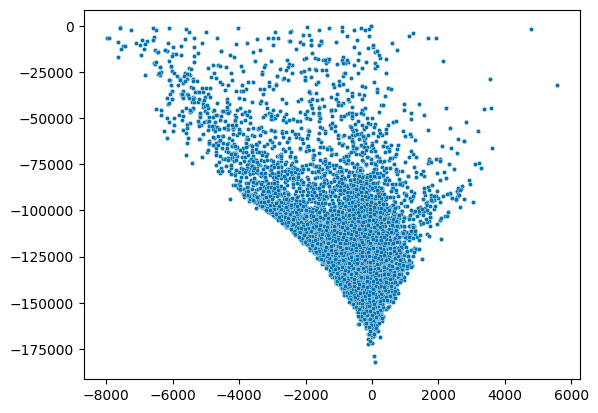

In [24]:
sns.scatterplot(x=X[:,3], y=X[:,0], s=10)

<AxesSubplot: >

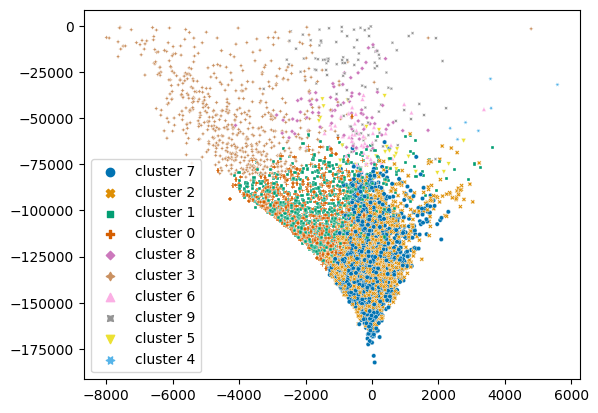

In [25]:
sns.scatterplot(x=X[:,3], y=X[:,0], hue=clusters, style=clusters, s=10)

<AxesSubplot: >

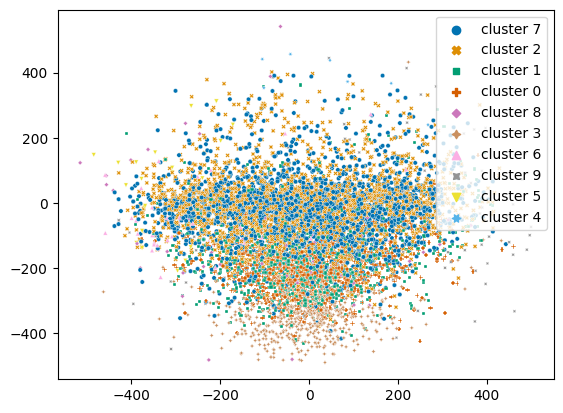

In [26]:
sns.scatterplot(x=X[:,9], y=X[:,10], hue=clusters, style=clusters, s=10)

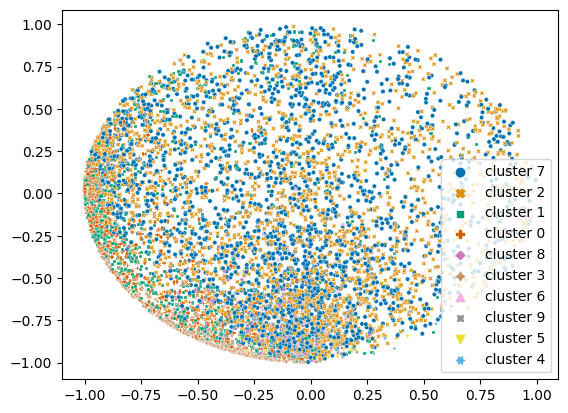

In [27]:
J = np.sqrt(X[:,3]**2 + X[:,2]**2 + X[:,1]**2)
ax = sns.scatterplot(x=X[:,3]/J, y=(X[:,2]-X[:,1])/J, hue=clusters, style=clusters, s=10)

[(0.0, 20000.0)]

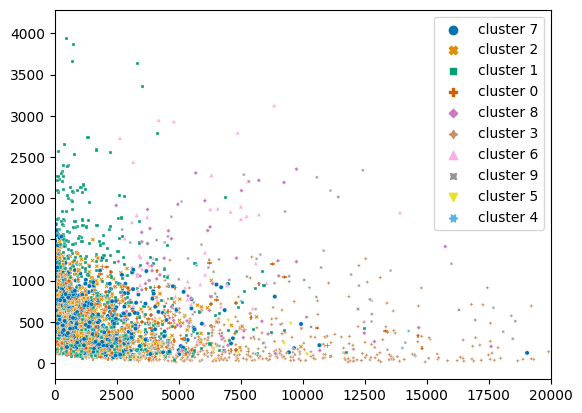

In [28]:
ax = sns.scatterplot(x=X[:,1], y=X[:,2], hue=clusters, style=clusters, s=10)
ax.set(xlim=[0,20000])

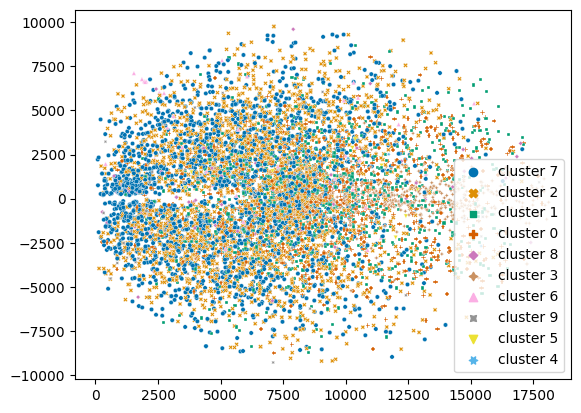

In [29]:
ax = sns.scatterplot(x=X[:,4], y=X[:,12], hue=clusters, style=clusters, s=10)

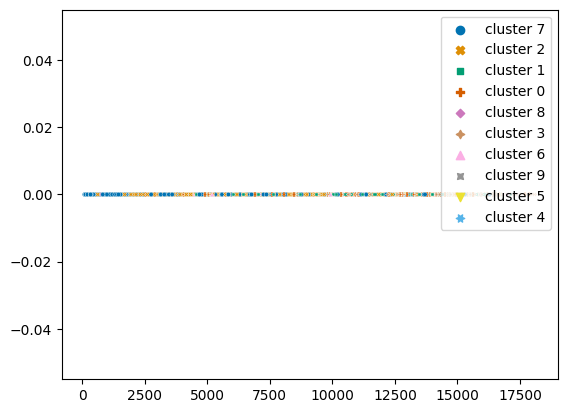

In [30]:
POS = [X[:,4]*torch.cos(X[:,11]),X[:,4]*torch.sin(X[:,11]),X[:,12]]
ax = sns.scatterplot(x=POS[0], y=POS[1], hue=clusters, style=clusters, s=10)

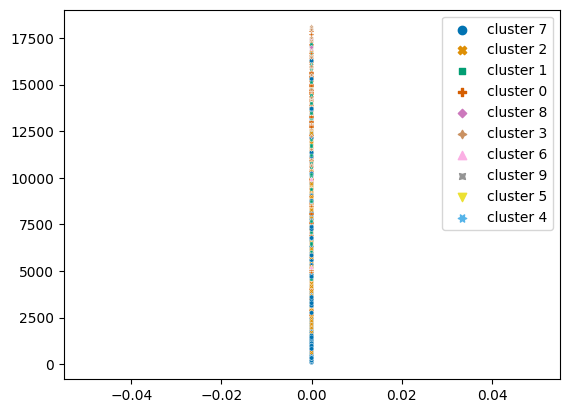

In [31]:
ax = sns.scatterplot(x=X[:,11], y=X[:,4], hue=clusters, style=clusters, s=10)